Error processing /Users/abubakr/Downloads/file/Spinal Cord Wedge Shape Plain.jpg: [Errno 30] Read-only file system: '/path'
Error processing /Users/abubakr/Downloads/file/png.png: [Errno 30] Read-only file system: '/path'


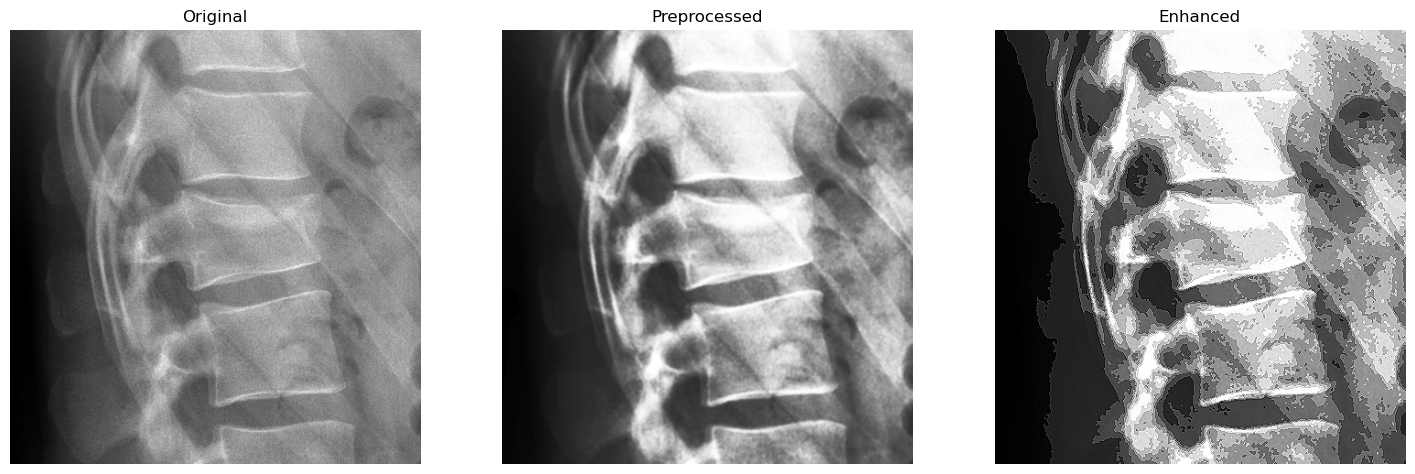

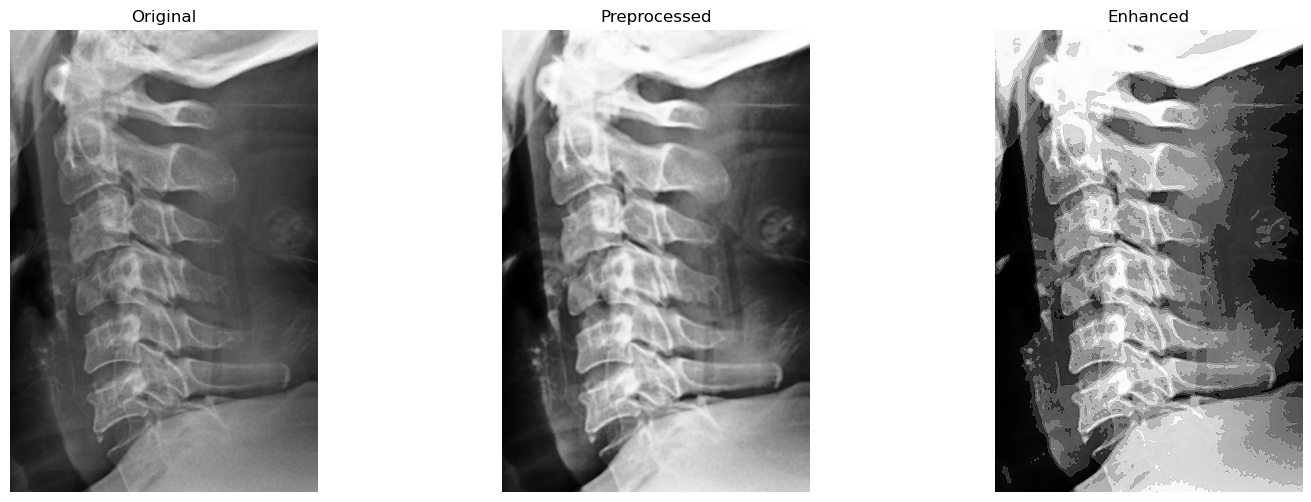

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from glob import glob

def load_image(image_path):
    abs_path = os.path.abspath(image_path)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {abs_path}")
    return img


def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    return equalized


def enhance_image_kmeans(image, n_clusters=8):
    pixel_values = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    segmented_pixels = centers[labels].reshape(image.shape)
    segmented = cv2.normalize(segmented_pixels, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return segmented


def blend_images(original, clustered, alpha=0.7):
    orig_f = original.astype(np.float32)
    clust_f = clustered.astype(np.float32)
    blended = alpha * clust_f + (1 - alpha) * orig_f
    return cv2.normalize(blended, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


def enhance_edges(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)


def process_xray_image(image_path, n_clusters=8, output_dir='output'):
    original = load_image(image_path)
    prep = preprocess_image(original)
    clustered = enhance_image_kmeans(prep, n_clusters)
    blended = blend_images(prep, clustered, alpha=0.7)
    final = enhance_edges(blended)

    # Save side-by-side comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = ['Original', 'Preprocessed', 'Enhanced']
    imgs = [original, prep, final]
    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(image_path))[0]
    out_path = os.path.join(output_dir, f"{base}_comparison.png")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close(fig)
    return final, out_path


def batch_process(folder_path, n_clusters=8, output_dir='output'):
    patterns = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    image_paths = []
    for pat in patterns:
        image_paths.extend(glob(os.path.join(folder_path, pat)))

    results = []
    for img_path in image_paths:
        try:
            enhanced, comp_path = process_xray_image(img_path, n_clusters, output_dir)
            print(f"Processed {img_path} -> {comp_path}")
            results.append((img_path, comp_path))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return results


if __name__ == '__main__':
    # Example usage:
    input_folder = '/Users/abubakr/Downloads/file'
    output_folder = '/path/to/output_dir'
    n_clusters = 8
    batch_process(input_folder, n_clusters, output_folder)
